In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import pickle
from catboost import CatBoostClassifier

from util import *

In [2]:
pd.options.display.max_columns = None

In [3]:
train_df = pd.read_parquet("data/data-3m.snappy.parquet")
#test_df = pd.read_parquet("data/data-202008.snappy.parquet")

In [4]:
train_df.columns

Index(['province_code', 'district_code', 'status_name', 'cust_name', 'msisdn',
       'ben_cust_name', 'ben_msisdn', 'request_date', 'viettel_bank_code',
       'channel_type_id', 'msisdn_channel', 'channel_code', 'staff_code',
       'trans_amount', 'trans_fee', 'trans_type', 'process_code',
       'channel_fee', 'shop_code', 'transfer_type', 'customer_fee',
       'fee_partner', 'is_fraud'],
      dtype='object')

In [5]:
features = [
    "province_code",
    "district_code",
    "viettel_bank_code",
    "channel_type_id",
    "channel_code",
    "staff_code",
    "trans_amount",
    "trans_fee",
    "trans_type",
    "process_code",
    "channel_fee",
    "shop_code",
    "customer_fee",
    "RW000076",
    "date_diff",
    "same_name",
    "same_phone",
    "same_phone_channel",
    "same_phone_channel_ben"
]
cat_features = ["province_code", "district_code","viettel_bank_code","channel_code"
                ,"staff_code","process_code","shop_code"]

X, y = preprocess_data(train_df, features, cat_features)

In [6]:
# y = train_df['is_fraud']
# X = train_df.drop(['is_fraud'], axis = 1)
# y_test = test_df['is_fraud']
# X_test = test_df.drop(['is_fraud'], axis = 1)
    
#X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=42)

In [7]:
cat_model = CatBoostClassifier(
    iterations=1000,
    max_ctr_complexity=1,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=25,
    depth=6,
    task_type="GPU",
    loss_function="Logloss",
    eval_metric="AUC"
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
)

Learning rate set to 0.031154
0:	learn: 0.8480520	test: 0.8470250	best: 0.8470250 (0)	total: 426ms	remaining: 7m 5s
25:	learn: 0.9940110	test: 0.9941734	best: 0.9941734 (25)	total: 11.9s	remaining: 7m 25s
50:	learn: 0.9941897	test: 0.9943454	best: 0.9943564 (40)	total: 23.6s	remaining: 7m 20s
75:	learn: 0.9943531	test: 0.9944986	best: 0.9944986 (75)	total: 35.4s	remaining: 7m 10s
100:	learn: 0.9945624	test: 0.9947093	best: 0.9947093 (100)	total: 47.2s	remaining: 6m 59s
125:	learn: 0.9948630	test: 0.9950364	best: 0.9950364 (125)	total: 59.2s	remaining: 6m 50s
150:	learn: 0.9952177	test: 0.9953828	best: 0.9953828 (150)	total: 1m 11s	remaining: 6m 41s
175:	learn: 0.9954900	test: 0.9956438	best: 0.9956438 (175)	total: 1m 23s	remaining: 6m 31s
200:	learn: 0.9956013	test: 0.9957480	best: 0.9957480 (200)	total: 1m 36s	remaining: 6m 21s
225:	learn: 0.9956684	test: 0.9958075	best: 0.9958075 (225)	total: 1m 48s	remaining: 6m 12s
250:	learn: 0.9957133	test: 0.9958464	best: 0.9958464 (250)	total: 

In [8]:
#save_model(cat_model, 'cat-model.saved')
import gc
pickle.dump(cat_model, open('cat-model.saved', 'wb'))
del X_train, X_val, y_train, y_val
gc.collect()

22

In [9]:
loaded_cat_model = pickle.load(open('cat-model.saved', 'rb'))

In [10]:
test_df = pd.read_parquet("data/data-202008.snappy.parquet")
X_test, y_test = preprocess_data(test_df, features, cat_features)

In [11]:
eval_model(loaded_cat_model, X_test, y_test)

classification_report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7339993
           1       0.80      0.62      0.70     27674

    accuracy                           1.00   7367667
   macro avg       0.90      0.81      0.85   7367667
weighted avg       1.00      1.00      1.00   7367667

confusion_matrix: 
[[7335757    4236]
 [  10557   17117]]
roc_auc_score: 0.8089728444591135
precision_score: 0.801620381211071
recall_score: 0.6185228011852281
f1_score: 0.6982683011401881


In [13]:
# from multiprocessing import Pool
# import shap
# shap_values = loaded_cat_model.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_features), type="ShapValues")
# explainer = shap.Explainer(loaded_cat_model)
# shap_values = explainer(X_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

In [15]:
df_feature_importance = pd.DataFrame(loaded_cat_model.feature_importances_, index=features, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
process_code,48.150590
same_phone,8.145786
trans_fee,6.947499
RW000076,5.513174
channel_fee,5.047598
customer_fee,4.535944
date_diff,3.851257
trans_amount,3.732329
staff_code,3.727972
trans_type,2.603750


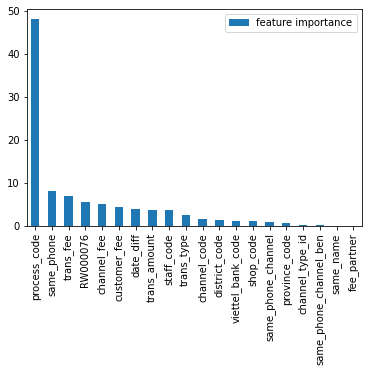

In [16]:
df_feature_importance.plot(kind='bar');

In [17]:
def plot_feature_importance(model, features):
    feature_importances = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value', 'Feature'])
    plt.figure(figsize=(20,10))
    sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

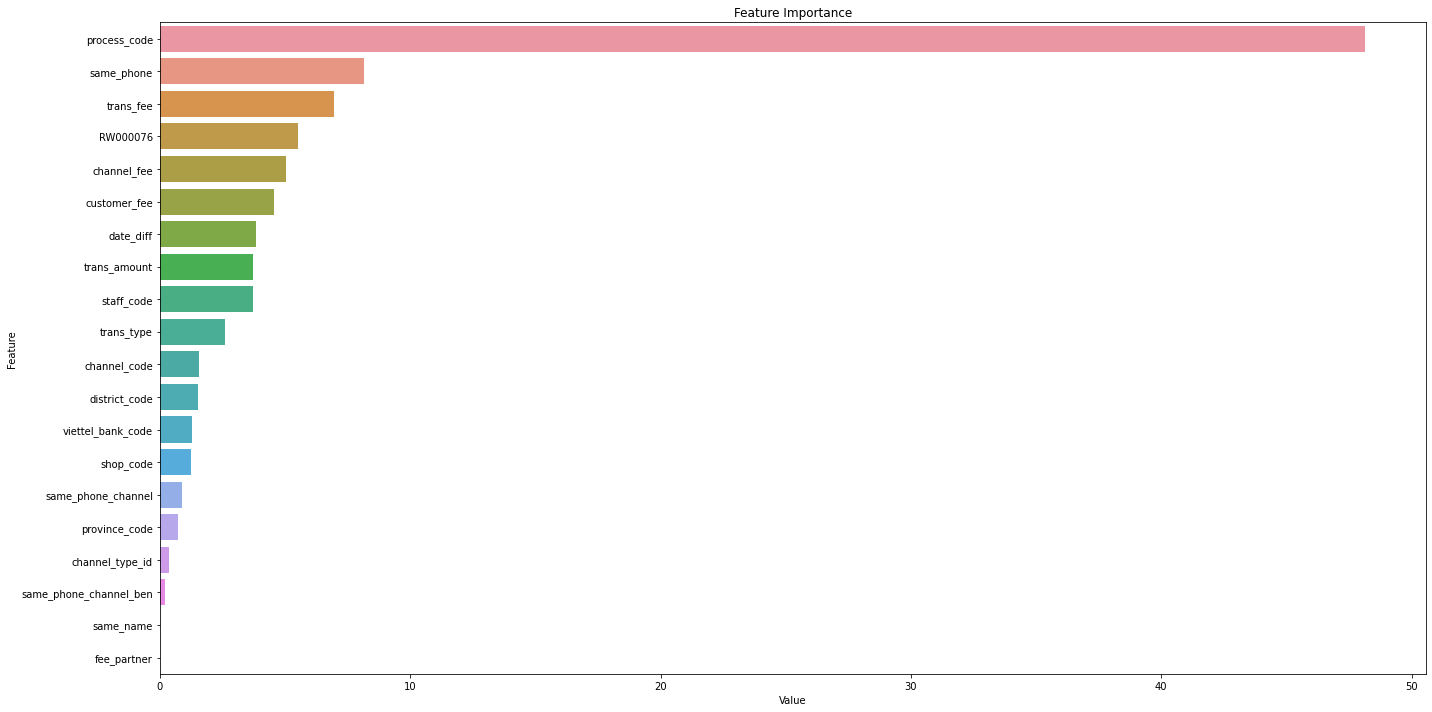

In [18]:
plot_feature_importance(loaded_cat_model, features)